# Steps 2.2-2.4: Model Training V3 - Exclude Followers
## LinkedIn Engagement Prediction - TrendPilot

**Date:** February 9, 2026  
**Version:** 3.0 (Exclude Followers Feature)  
**Objective:** Train ML models without followers feature to test content-only prediction

---

## 🆕 V3 CHANGES

### Key Change from V2:
- **EXCLUDE FOLLOWERS:** Remove the `followers` feature to test whether engagement is predictable from content alone
- Rationale: In a real-world deployment scenario, we may not always have access to the influencer's follower count
- This tests the robustness of our content-based features (text, NLP, structure, etc.)

### What's the Same as V2:
✅ No data leakage (6 leakage features removed)  
✅ Proper MAPE calculation (handles zeros)  
✅ Clean features only (no target-derived signals)  

---

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import joblib
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported")

✓ Libraries imported


## 1. Data Loading & Leakage Detection

In [24]:
# Load data
data = pd.read_csv('../data/selected_features_data.csv')

print(f"Dataset: {data.shape[0]:,} rows × {data.shape[1]} columns\n")

# Identify leakage features (features derived from targets)
LEAKAGE_FEATURES = [
    'reactions_per_sentiment',      # reactions / (sentiment + 1)
    'reactions_per_word',            # reactions / word_count
    'comments_per_word',             # comments / word_count
    'reactions_vs_influencer_avg',  # reactions - influencer_avg
    'comments_vs_influencer_avg',   # comments - influencer_avg
    'comment_to_reaction_ratio'     # comments / reactions
]

print("🚨 LEAKAGE FEATURES TO REMOVE:")
for feat in LEAKAGE_FEATURES:
    if feat in data.columns:
        print(f"  ✗ {feat}")
    
# Remove leakage features
data_clean = data.drop(columns=LEAKAGE_FEATURES, errors='ignore')

print(f"\n✓ Removed {len(LEAKAGE_FEATURES)} leakage features")
print(f"✓ Clean dataset: {data_clean.shape[0]:,} rows × {data_clean.shape[1]} columns")

Dataset: 31,996 rows × 98 columns

🚨 LEAKAGE FEATURES TO REMOVE:
  ✗ reactions_per_sentiment
  ✗ reactions_per_word
  ✗ comments_per_word
  ✗ reactions_vs_influencer_avg
  ✗ comments_vs_influencer_avg
  ✗ comment_to_reaction_ratio

✓ Removed 6 leakage features
✓ Clean dataset: 31,996 rows × 92 columns


## 2. Feature Preparation (Excluding Followers)

In [25]:
# Prepare features and targets
# V3: Adding 'followers' AND 'influencer_avg_engagement' to exclusion list
EXCLUDE_COLUMNS = ['reactions', 'comments', 'name', 'slno', 'content', 'time_spent', 'location', 'followers', 'influencer_avg_engagement', 'influencer_total_engagement']

feature_columns = [col for col in data_clean.columns if col not in EXCLUDE_COLUMNS]

print(f"🆕 V3: Excluding 'followers' AND 'influencer_avg_engagement' to test pure content prediction\n")

X = data_clean[feature_columns]
y_reactions = data_clean['reactions']
y_comments = data_clean['comments']

# Check for NaN values
nan_counts = X.isna().sum()
if nan_counts.sum() > 0:
    print(f"⚠️ Found NaN values in {(nan_counts > 0).sum()} features:")
    for col in nan_counts[nan_counts > 0].index:
        print(f"  - {col}: {nan_counts[col]} NaNs")
    
    # Fill NaN with median
    print("\n🔧 Filling NaN values with median...")
    X = X.fillna(X.median())
    print("✓ NaN values handled")

print(f"\nFeature matrix: {X.shape}")
print(f"Target (reactions): {y_reactions.shape}")
print(f"Target (comments): {y_comments.shape}")
print(f"\nValid features (no followers, no influencer_avg_engagement): {len(feature_columns)}")

print(f"\n📊 Target Statistics:")
reactions_zeros = (y_reactions == 0).sum()
comments_zeros = (y_comments == 0).sum()
print(f"Reactions = 0: {reactions_zeros:,} ({reactions_zeros / len(y_reactions) * 100:.2f}%)")
print(f"Comments = 0: {comments_zeros:,} ({comments_zeros / len(y_comments) * 100:.2f}%)")

🆕 V3: Excluding 'followers' AND 'influencer_avg_engagement' to test pure content prediction


Feature matrix: (31996, 82)
Target (reactions): (31996,)
Target (comments): (31996,)

Valid features (no followers, no influencer_avg_engagement): 82

📊 Target Statistics:
Reactions = 0: 750 (2.34%)
Comments = 0: 9,728 (30.40%)


## 3. Train-Test Split

In [26]:
# Split data
X_train, X_test, y_train_reactions, y_test_reactions = train_test_split(
    X, y_reactions, test_size=0.2, random_state=42
)

X_train, X_test, y_train_comments, y_test_comments = train_test_split(
    X, y_comments, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTrain/Test ratio: {X_train.shape[0] / X_test.shape[0]:.1f}")
print("\n✓ Data split complete")

Training set: 25,596 samples
Test set: 6,400 samples

Train/Test ratio: 4.0

✓ Data split complete


## 4. Custom MAPE Function (Handle Zeros)

In [27]:
def safe_mape(y_true, y_pred, epsilon=1e-10):
    """
    Calculate MAPE excluding zero values in y_true.
    
    Args:
        y_true: Actual values
        y_pred: Predicted values
        epsilon: Small value to avoid division by zero
    
    Returns:
        MAPE as percentage, or None if all values are zero
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Mask out zeros
    non_zero_mask = y_true > epsilon
    
    if not non_zero_mask.any():
        return None  # All zeros, MAPE undefined
    
    y_true_masked = y_true[non_zero_mask]
    y_pred_masked = y_pred[non_zero_mask]
    
    mape = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100
    
    return mape

def evaluate_model(y_true, y_pred, model_name="Model"):
    """Evaluate model with all metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = safe_mape(y_true, y_pred)
    
    return {
        'model': model_name,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape if mape is not None else np.nan
    }

print("✓ Custom MAPE function defined")
print("✓ This properly handles zero values by excluding them from calculation")

✓ Custom MAPE function defined
✓ This properly handles zero values by excluding them from calculation


## 5. Model Training - Reactions

In [28]:
print("="*80)
print("TRAINING MODELS FOR REACTIONS PREDICTION (V3 - PURE CONTENT ONLY)")
print("="*80)

results_reactions = []

# 1. Linear Regression
print("\n1. Training Linear Regression...")
lr_reactions = LinearRegression()
lr_reactions.fit(X_train, y_train_reactions)
y_pred = lr_reactions.predict(X_test)
results_reactions.append(evaluate_model(y_test_reactions, y_pred, "Linear Regression"))
print(f"   MAE: {results_reactions[-1]['mae']:.2f}, RMSE: {results_reactions[-1]['rmse']:.2f}, R²: {results_reactions[-1]['r2']:.4f}, MAPE: {results_reactions[-1]['mape']:.2f}%")

# 2. Random Forest
print("\n2. Training Random Forest...")
rf_reactions = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_reactions.fit(X_train, y_train_reactions)
y_pred = rf_reactions.predict(X_test)
results_reactions.append(evaluate_model(y_test_reactions, y_pred, "Random Forest"))
print(f"   MAE: {results_reactions[-1]['mae']:.2f}, RMSE: {results_reactions[-1]['rmse']:.2f}, R²: {results_reactions[-1]['r2']:.4f}, MAPE: {results_reactions[-1]['mape']:.2f}%")

# 3. XGBoost
print("\n3. Training XGBoost...")
xgb_reactions = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_reactions.fit(X_train, y_train_reactions)
y_pred = xgb_reactions.predict(X_test)
results_reactions.append(evaluate_model(y_test_reactions, y_pred, "XGBoost"))
print(f"   MAE: {results_reactions[-1]['mae']:.2f}, RMSE: {results_reactions[-1]['rmse']:.2f}, R²: {results_reactions[-1]['r2']:.4f}, MAPE: {results_reactions[-1]['mape']:.2f}%")

# 4. LightGBM
print("\n4. Training LightGBM...")
lgb_reactions = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_reactions.fit(X_train, y_train_reactions)
y_pred = lgb_reactions.predict(X_test)
results_reactions.append(evaluate_model(y_test_reactions, y_pred, "LightGBM"))
print(f"   MAE: {results_reactions[-1]['mae']:.2f}, RMSE: {results_reactions[-1]['rmse']:.2f}, R²: {results_reactions[-1]['r2']:.4f}, MAPE: {results_reactions[-1]['mape']:.2f}%")

print("\n✓ Reactions models trained (V3 - pure content only, no influencer history)")

TRAINING MODELS FOR REACTIONS PREDICTION (V3 - PURE CONTENT ONLY)

1. Training Linear Regression...
   MAE: 432.12, RMSE: 849.82, R²: 0.1828, MAPE: 3595.80%

2. Training Random Forest...
   MAE: 191.88, RMSE: 597.85, R²: 0.5955, MAPE: 205.18%

3. Training XGBoost...
   MAE: 195.53, RMSE: 592.07, R²: 0.6033, MAPE: 362.90%

4. Training LightGBM...
   MAE: 198.47, RMSE: 603.07, R²: 0.5885, MAPE: 377.66%

✓ Reactions models trained (V3 - pure content only, no influencer history)


## 6. Model Training - Comments

In [29]:
print("="*80)
print("TRAINING MODELS FOR COMMENTS PREDICTION (V3 - PURE CONTENT ONLY)")
print("="*80)

results_comments = []

# 1. Linear Regression
print("\n1. Training Linear Regression...")
lr_comments = LinearRegression()
lr_comments.fit(X_train, y_train_comments)
y_pred = lr_comments.predict(X_test)
results_comments.append(evaluate_model(y_test_comments, y_pred, "Linear Regression"))
print(f"   MAE: {results_comments[-1]['mae']:.2f}, RMSE: {results_comments[-1]['rmse']:.2f}, R²: {results_comments[-1]['r2']:.4f}, MAPE: {results_comments[-1]['mape']:.2f}%")

# 2. Random Forest
print("\n2. Training Random Forest...")
rf_comments = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_comments.fit(X_train, y_train_comments)
y_pred = rf_comments.predict(X_test)
results_comments.append(evaluate_model(y_test_comments, y_pred, "Random Forest"))
print(f"   MAE: {results_comments[-1]['mae']:.2f}, RMSE: {results_comments[-1]['rmse']:.2f}, R²: {results_comments[-1]['r2']:.4f}, MAPE: {results_comments[-1]['mape']:.2f}%")

# 3. XGBoost
print("\n3. Training XGBoost...")
xgb_comments = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_comments.fit(X_train, y_train_comments)
y_pred = xgb_comments.predict(X_test)
results_comments.append(evaluate_model(y_test_comments, y_pred, "XGBoost"))
print(f"   MAE: {results_comments[-1]['mae']:.2f}, RMSE: {results_comments[-1]['rmse']:.2f}, R²: {results_comments[-1]['r2']:.4f}, MAPE: {results_comments[-1]['mape']:.2f}%")

# 4. LightGBM
print("\n4. Training LightGBM...")
lgb_comments = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_comments.fit(X_train, y_train_comments)
y_pred = lgb_comments.predict(X_test)
results_comments.append(evaluate_model(y_test_comments, y_pred, "LightGBM"))
print(f"   MAE: {results_comments[-1]['mae']:.2f}, RMSE: {results_comments[-1]['rmse']:.2f}, R²: {results_comments[-1]['r2']:.4f}, MAPE: {results_comments[-1]['mape']:.2f}%")

print("\n✓ Comments models trained (V3 - pure content only, no influencer history)")

TRAINING MODELS FOR COMMENTS PREDICTION (V3 - PURE CONTENT ONLY)

1. Training Linear Regression...
   MAE: 26.53, RMSE: 48.33, R²: 0.1662, MAPE: 575.02%

2. Training Random Forest...
   MAE: 15.13, RMSE: 36.51, R²: 0.5240, MAPE: 161.76%

3. Training XGBoost...
   MAE: 15.22, RMSE: 36.25, R²: 0.5309, MAPE: 172.71%

4. Training LightGBM...
   MAE: 15.40, RMSE: 36.27, R²: 0.5305, MAPE: 173.62%

✓ Comments models trained (V3 - pure content only, no influencer history)


## 7. Model Comparison

In [30]:
# Create comparison dataframes
df_reactions = pd.DataFrame(results_reactions).sort_values('r2', ascending=False)
df_comments = pd.DataFrame(results_comments).sort_values('r2', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON - REACTIONS (V3 - PURE CONTENT)")
print("="*80)
print(df_reactions.to_string(index=False))

print("\n" + "="*80)
print("MODEL COMPARISON - COMMENTS (V3 - PURE CONTENT)")
print("="*80)
print(df_comments.to_string(index=False))

# Select best models
best_reactions_model_name = df_reactions.iloc[0]['model']
best_comments_model_name = df_comments.iloc[0]['model']

print(f"\n✓ Best model for reactions: {best_reactions_model_name}")
print(f"✓ Best model for comments: {best_comments_model_name}")

# Get best model objects
model_dict_reactions = {
    'Linear Regression': lr_reactions,
    'Random Forest': rf_reactions,
    'XGBoost': xgb_reactions,
    'LightGBM': lgb_reactions
}

model_dict_comments = {
    'Linear Regression': lr_comments,
    'Random Forest': rf_comments,
    'XGBoost': xgb_comments,
    'LightGBM': lgb_comments
}

best_reactions_model = model_dict_reactions[best_reactions_model_name]
best_comments_model = model_dict_comments[best_comments_model_name]


MODEL COMPARISON - REACTIONS (V3 - PURE CONTENT)
            model        mae       rmse       r2        mape
          XGBoost 195.530786 592.074603 0.603321  362.899857
    Random Forest 191.875951 597.851517 0.595542  205.178681
         LightGBM 198.470376 603.066362 0.588456  377.662879
Linear Regression 432.123684 849.820755 0.182776 3595.804601

MODEL COMPARISON - COMMENTS (V3 - PURE CONTENT)
            model       mae      rmse       r2       mape
          XGBoost 15.216082 36.248906 0.530909 172.705495
         LightGBM 15.404574 36.265816 0.530471 173.620425
    Random Forest 15.134821 36.514155 0.524018 161.759592
Linear Regression 26.526302 48.327056 0.166226 575.023182

✓ Best model for reactions: XGBoost
✓ Best model for comments: XGBoost


## 8. Visualization

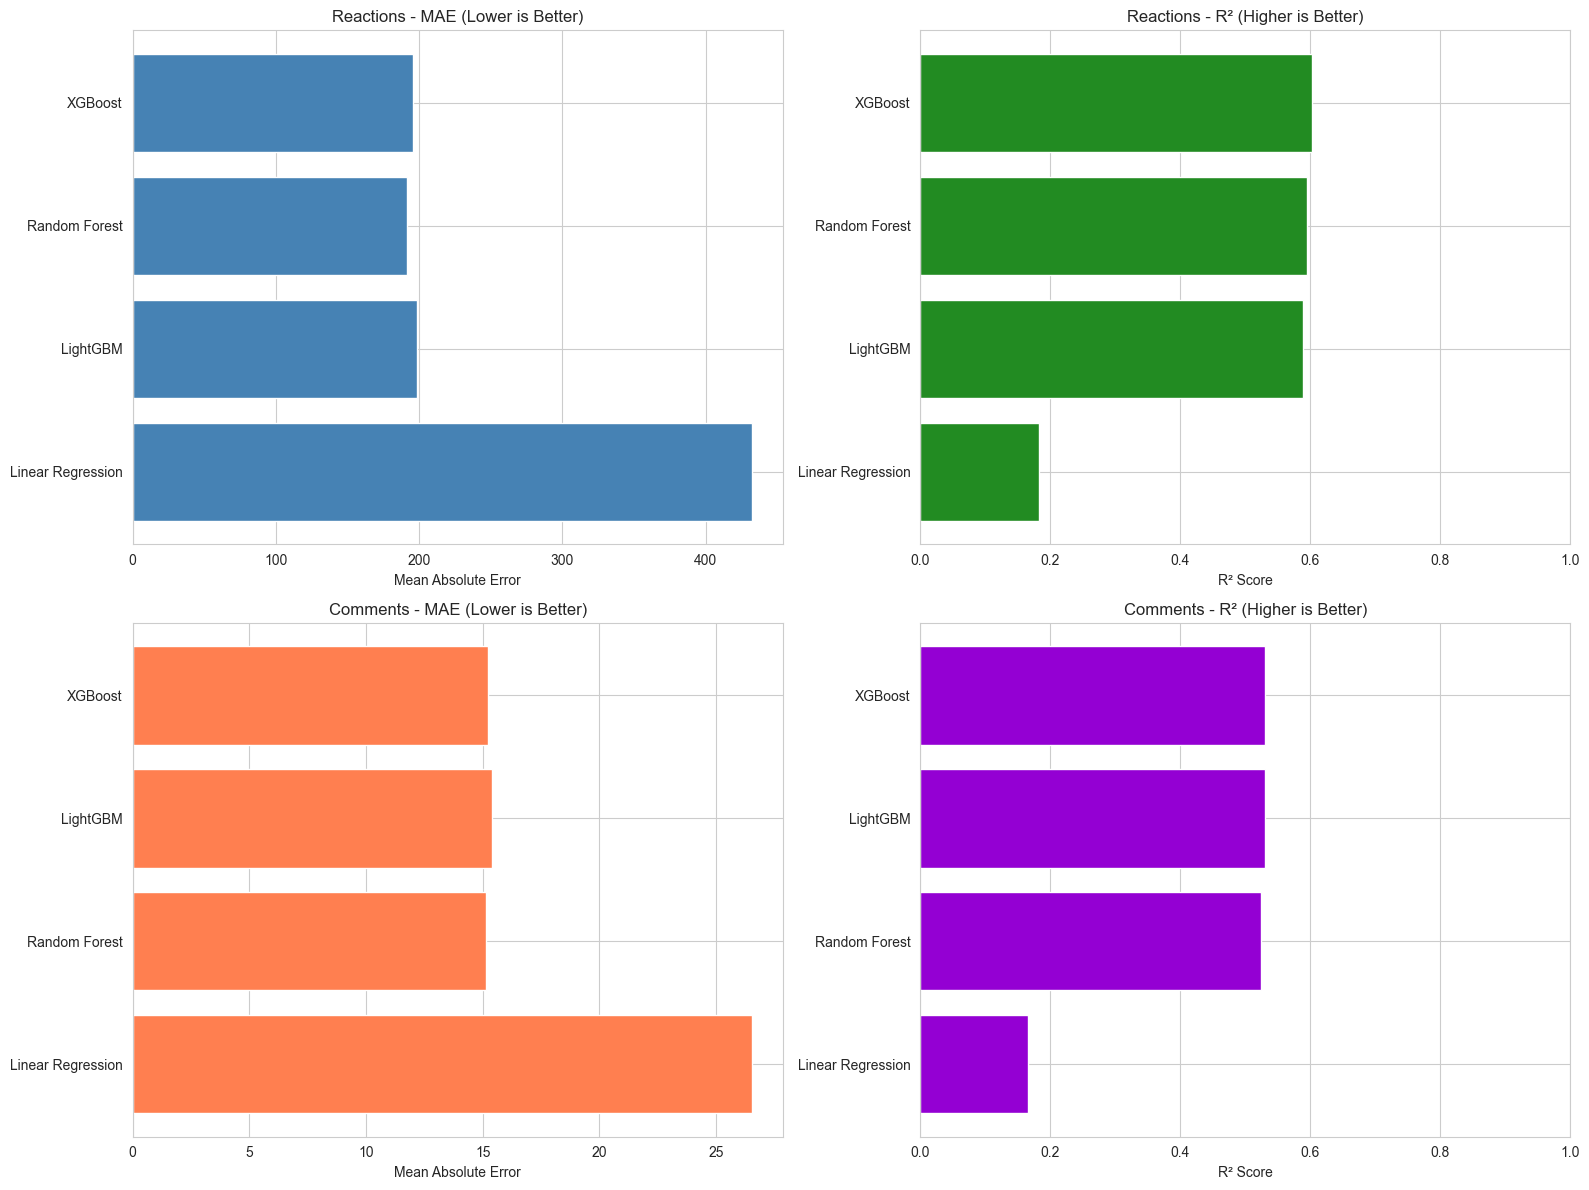

✓ Model comparison visualized


In [31]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Reactions - MAE
axes[0, 0].barh(df_reactions['model'], df_reactions['mae'], color='steelblue')
axes[0, 0].set_xlabel('Mean Absolute Error')
axes[0, 0].set_title('Reactions - MAE (Lower is Better)')
axes[0, 0].invert_yaxis()

# Reactions - R²
axes[0, 1].barh(df_reactions['model'], df_reactions['r2'], color='forestgreen')
axes[0, 1].set_xlabel('R² Score')
axes[0, 1].set_title('Reactions - R² (Higher is Better)')
axes[0, 1].invert_yaxis()
axes[0, 1].set_xlim(0, 1)

# Comments - MAE
axes[1, 0].barh(df_comments['model'], df_comments['mae'], color='coral')
axes[1, 0].set_xlabel('Mean Absolute Error')
axes[1, 0].set_title('Comments - MAE (Lower is Better)')
axes[1, 0].invert_yaxis()

# Comments - R²
axes[1, 1].barh(df_comments['model'], df_comments['r2'], color='darkviolet')
axes[1, 1].set_xlabel('R² Score')
axes[1, 1].set_title('Comments - R² (Higher is Better)')
axes[1, 1].invert_yaxis()
axes[1, 1].set_xlim(0, 1)

plt.tight_layout()
os.makedirs('../visualizations', exist_ok=True)
plt.savefig('../visualizations/model_comparison_v3_no_followers.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Model comparison visualized")

## 9. Feature Importance

In [32]:
# Get feature importance from best models (if tree-based)
if hasattr(best_reactions_model, 'feature_importances_'):
    importance_reactions = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_reactions_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 15 features for REACTIONS:")
    print(importance_reactions.head(15).to_string(index=False))
else:
    print("\nReactions model does not have feature_importances_ (likely Linear Regression)")

if hasattr(best_comments_model, 'feature_importances_'):
    importance_comments = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_comments_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 15 features for COMMENTS:")
    print(importance_comments.head(15).to_string(index=False))
else:
    print("\nComments model does not have feature_importances_ (likely Linear Regression)")

print("\n✓ Feature importance analysis complete")
print("  Note: No followers, no influencer_avg_engagement - pure content only!")


Top 15 features for REACTIONS:
                         feature  importance
influencer_consistency_reactions    0.085285
       influencer_avg_base_score    0.072848
                    has_entities    0.062787
           influencer_post_count    0.062190
        influencer_avg_sentiment    0.040792
         hashtag_count_extracted    0.038884
               has_external_link    0.031006
                       has_image    0.027190
              ner_total_entities    0.022451
      text_difficult_words_ratio    0.019242
               has_value_promise    0.015805
                     media_score    0.015203
                style_has_quotes    0.014862
              style_number_count    0.014114
                topic_leadership    0.013529

Top 15 features for COMMENTS:
                         feature  importance
influencer_consistency_reactions    0.099425
                    has_entities    0.063908
           influencer_post_count    0.057143
                  is_multi_topic    0

## 10. Save Models

In [33]:
# Create models directory
os.makedirs('../models_v3', exist_ok=True)

# Save best models
joblib.dump(best_reactions_model, '../models_v3/best_reactions_model_v3.pkl')
joblib.dump(best_comments_model, '../models_v3/best_comments_model_v3.pkl')

# Save feature list
with open('../models_v3/feature_list_v3.json', 'w') as f:
    json.dump(feature_columns, f, indent=2)

# Save metadata
metadata = {
    'version': '3.0',
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'key_change': 'Excluded followers feature to test content-only prediction',
    'leakage_features_removed': LEAKAGE_FEATURES,
    'excluded_features': EXCLUDE_COLUMNS,
    'reactions_model': {
        'type': best_reactions_model_name,
        'performance': {
            'mae': float(df_reactions.iloc[0]['mae']),
            'rmse': float(df_reactions.iloc[0]['rmse']),
            'r2': float(df_reactions.iloc[0]['r2']),
            'mape': float(df_reactions.iloc[0]['mape']) if not pd.isna(df_reactions.iloc[0]['mape']) else None
        },
        'feature_count': len(feature_columns)
    },
    'comments_model': {
        'type': best_comments_model_name,
        'performance': {
            'mae': float(df_comments.iloc[0]['mae']),
            'rmse': float(df_comments.iloc[0]['rmse']),
            'r2': float(df_comments.iloc[0]['r2']),
            'mape': float(df_comments.iloc[0]['mape']) if not pd.isna(df_comments.iloc[0]['mape']) else None
        },
        'feature_count': len(feature_columns)
    },
    'training_data': {
        'total_samples': len(X),
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'reactions_zeros': int(reactions_zeros),
        'comments_zeros': int(comments_zeros)
    }
}

with open('../models_v3/model_metadata_v3.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✓ Models saved to ../models_v3/")
print("  - best_reactions_model_v3.pkl")
print("  - best_comments_model_v3.pkl")
print("  - feature_list_v3.json")
print("  - model_metadata_v3.json")

print("\n" + "="*80)
print("SUCCESS: V3 Models Trained Without Followers Feature!")
print("="*80)

print(f"\nReactions Model ({best_reactions_model_name}):")
print(f"  MAE: {df_reactions.iloc[0]['mae']:.2f}")
print(f"  RMSE: {df_reactions.iloc[0]['rmse']:.2f}")
print(f"  R²: {df_reactions.iloc[0]['r2']:.4f}")
print(f"  MAPE: {df_reactions.iloc[0]['mape']:.2f}%")

print(f"\nComments Model ({best_comments_model_name}):")
print(f"  MAE: {df_comments.iloc[0]['mae']:.2f}")
print(f"  RMSE: {df_comments.iloc[0]['rmse']:.2f}")
print(f"  R²: {df_comments.iloc[0]['r2']:.4f}")
print(f"  MAPE: {df_comments.iloc[0]['mape']:.2f}%")

print("\n✅ These models use pure content features only!")
print("✅ No influencer history - tests pure content quality prediction.")

✓ Models saved to ../models_v3/
  - best_reactions_model_v3.pkl
  - best_comments_model_v3.pkl
  - feature_list_v3.json
  - model_metadata_v3.json

SUCCESS: V3 Models Trained Without Followers Feature!

Reactions Model (XGBoost):
  MAE: 195.53
  RMSE: 592.07
  R²: 0.6033
  MAPE: 362.90%

Comments Model (XGBoost):
  MAE: 15.22
  RMSE: 36.25
  R²: 0.5309
  MAPE: 172.71%

✅ These models use pure content features only!
✅ No influencer history - tests pure content quality prediction.
